In [29]:
!pip install gensim


In [25]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)


<ipython-input-25-455f5fe2dfe9>:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [30]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
# from sklearn.externals import joblib
import gensim
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')
np.random.seed(37)




C:\Users\infom\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Loading the data 

In [19]:
df = pd.read_excel("text_classification_dataset.xlsx")
df = df.reindex(np.random.permutation(df.index))
df.head()

,text,type
170,RT @Drift0r: Finally watched Joker. It is an i...,entertainment
1150,The most fun tennis games ever! #Rally4Relief ...,sports
1093,RT @world_nugget: Some of the biggest names in...,sports
213,RT @fourdeadkids: after 5 years: jan with his ...,entertainment
128,@InMyOwnBubble_ Yep nobody can rule Indian cri...,sports


## Exploratory Data Analysis

C:\Users\infom\anaconda3\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\infom\anaconda3\lib\site-packages\seaborn\categorical.py:3710: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


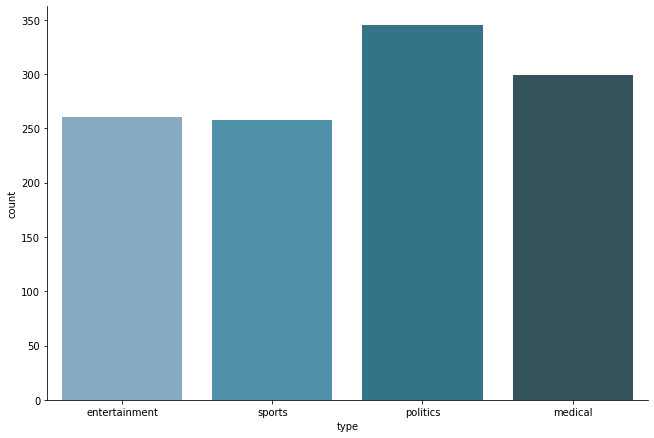

In [20]:
sns.factorplot(x = "type", data = df, kind = "count", size = 6, aspect = 1.5, palette = "PuBuGn_d")

## Lets check Input Variables

In [35]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df
tc = TextCounts()
df_eda = tc.fit_transform(df.text)
df_eda['type'] = df.type
df_eda

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,type
170,24,1,0,2,0,0,0,entertainment
1150,11,0,1,0,1,1,0,sports
1093,25,1,0,1,0,0,0,sports
213,26,1,0,1,0,0,0,entertainment
128,16,1,0,0,0,0,0,sports
...,...,...,...,...,...,...,...,...
317,11,1,0,0,0,0,0,entertainment
707,20,0,0,1,0,1,0,politics
497,20,1,1,2,0,0,0,medical
966,20,0,0,0,0,1,0,politics


## Text Cleaning

In [54]:

class CleanText(BaseEstimator, TransformerMixin):
   
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

170     RT @Drift0r: Finally watched Joker. It is an incredible film and deserving of its Oscar nominations. Probably the best movie DC has ever ma…   
1150    The most fun tennis games ever! #Rally4Relief https://t.co/SHcV9kOwxI                                                                          
1093    RT @world_nugget: Some of the biggest names in tennis have teamed up to raise funds for the bushfire appeal on a magical night in Melbourne…   
213     RT @fourdeadkids: after 5 years: jan with his degree, jan has his own movie, jan became a singer, jan has big fanbases, jan was paired with…   
128     @InMyOwnBubble_ Yep nobody can rule Indian cricket like Dhoni.. Thala illama match paaka interest ey varala :(                                 
                                                             ...                                                                                       
317     @davecokin he's goin down like a tranny @ a Queen concert                       

In [70]:
ct = CleanText()
sr_clean = ct.fit_transform(df.text)
df["clean_text"] = sr_clean
df_clean = df[["clean_text","type"]]
df_clean

,clean_text,type
170,rt final watch joker incred film deserv oscar nomin probabl best movi dc ever ma…,entertainment
1150,fun tenni game ever rallyrelief,sports
1093,rt biggest name tenni team rais fund bushfir appeal magic night melbourne…,sports
213,rt year jan degre jan movi jan becam singer jan big fanbas jan pair with…,entertainment
128,yep nobodi rule indian cricket like dhoni thala illama match paaka interest ey varala,sports
...,...,...
317,goin like tranni queen concert,entertainment
707,french prosecutor probe socialist royal fund use ambassador por reuter publicado en el nyt,politics
497,rt ziplin technolog made medic deliveri drone juansa health centr asant aky north district thechange…,medical
966,ukrain prosecutor offer inform relat biden exchang ambassador’ ouster newli releas materia…,politics


In [71]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)


In [72]:
df_model = df_clean

df_model.columns.tolist()

['clean_text', 'type']

In [ ]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols
    def transform(self, X, **transform_params):
        return X[self.cols]
    def fit(self, X, y=None, **fit_params):
        return self

In [75]:
df_model.head()
    
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('type', axis=1), df_model.type, test_size=0.1, random_state=37)
